In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gp
import xarray as xr
import datetime as dt
import rioxarray
import rasterio
from rasterio import features
import numpy as np
import xrspatial as xrs
from stats_functions import summarize_array_values

In [2]:
def time_index_from_monthly_filenames(filenames):
    '''helper function to create a pandas DatetimeIndex
       Filename example: AET_2002_03.tif'''
    dates = []
    files = []
    for f in filenames:
        month = str(f.stem).split('_')[2]
        year = str(f.stem).split('_')[1]
        day = 15
        date = dt.date(year=int(year), month=int(month), day=day)
        dates.append(date)
        files.append(str(f))

    dateindex = (pd.DatetimeIndex(dates))
    df = pd.DataFrame({'filename': files, 'date': dates, 'dateindex': dateindex})
    df.sort_values(by=['date'], inplace=True)
    return df

In [3]:
reitz_data_path = Path('D:/weather_and_geodata/reitz_2023')
surface_water_basins_shp = 'ALL_BASINS_FOR_OBS_GRID__EPSG_4269.shp'
filenames = reitz_data_path.glob('*.tif')
df = time_index_from_monthly_filenames((filenames))
#time = xr.Variable('time', time_index_from_filenames(filenames))
#chunks = {'x': 5490, 'y': 5490, 'band': 1}
#da = xr.concat([xr.open_rasterio(f, chunks=chunks) for f in filenames], dim=time)

In [4]:
time = xr.Variable('time', df.loc[:,'dateindex'])
#chunks = {'x': 3513, 'y': 3105, 'band': 1}
#da = xr.concat([rioxarray.open_rasterio(f, chunks=chunks, mask_and_scale=True) for f in df.loc[:,'filename']], dim=time).mean(dim='band')
da = xr.concat([rioxarray.open_rasterio(f, mask_and_scale=True) for f in df.loc[:,'filename']], dim=time).mean(dim='band')
reitz_sample_dataset = rioxarray.open_rasterio(df.loc[0,'filename']).squeeze()[0:1200,2900:5000]

In [5]:
len(reitz_sample_dataset)

1200

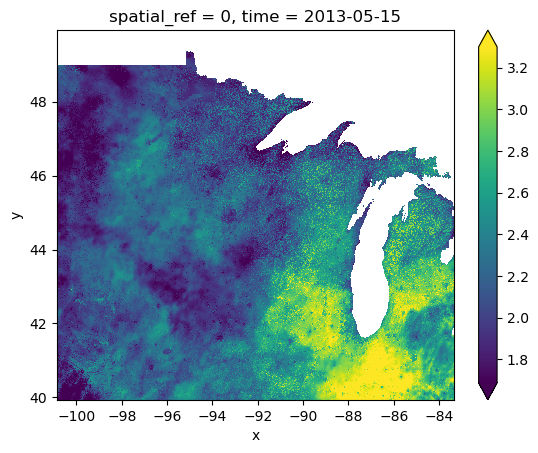

In [6]:
da[40,0:1200,2900:5000].plot(robust=True)

In [7]:
seasonal_da = da[:,0:1200,2900:5000].resample(time="QS-DEC").reduce(np.sum, dim="time")

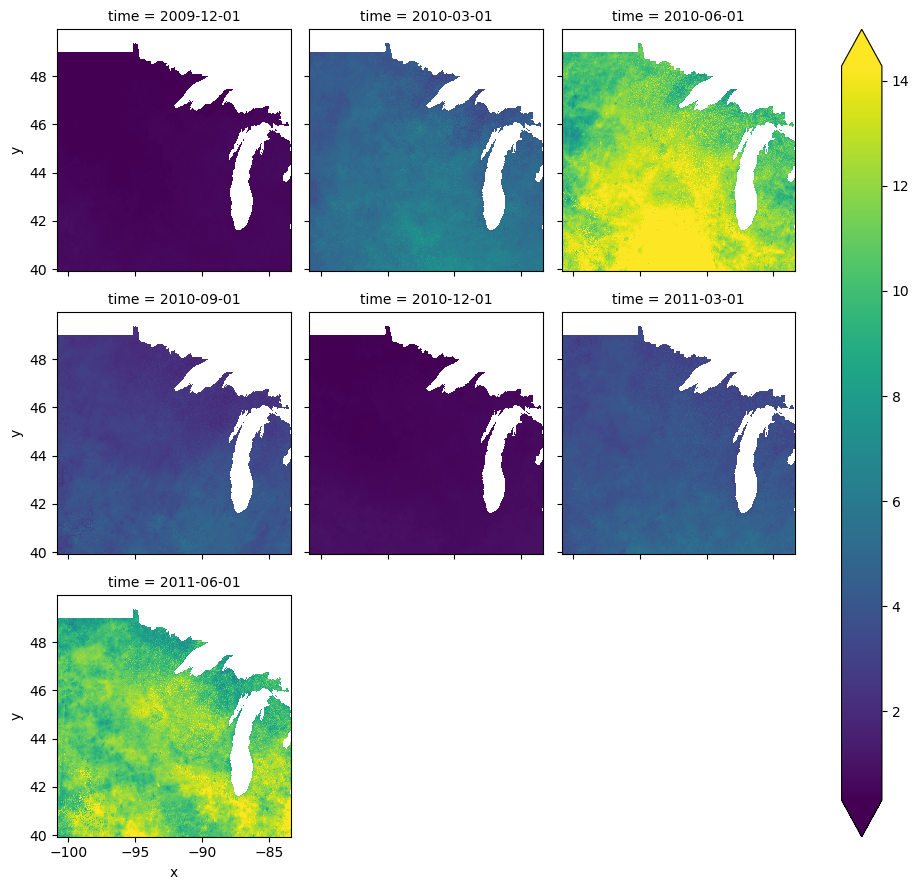

In [9]:
seasonal_da[0:7,:,:].plot(robust=True, col='time', col_wrap=3)

In [10]:
surface_water_basins_gdf = gp.read_file(surface_water_basins_shp)

In [11]:
surface_water_basins_gdf

,BASIN_INDX,station_nm,site_no,area_calc,geometry
0,0,"ST. LOUIS RIVER NEAR SKIBO, MN",4015438,100.843794,"POLYGON ((-91.76904 47.60841, -91.76827 47.608..."
1,1,"BOIS BRULE RIVER AT BRULE, WI",4025500,117.837260,"POLYGON ((-91.81467 46.46616, -91.81467 46.466..."
2,2,"STONEY BROOK AT PINE DRIVE NEAR BROOKSTON, MN",4021520,74.284679,"POLYGON ((-92.72605 46.83725, -92.72607 46.836..."
3,3,"WHITTLESEY CREEK NEAR ASHLAND, WI",40263205,28.258041,"POLYGON ((-91.18201 46.66996, -91.18203 46.669..."
4,4,"NORTH FISH CREEK NEAR MOQUAH, WI",40263491,79.151705,"POLYGON ((-91.18769 46.62976, -91.18773 46.629..."
...,...,...,...,...,...
65,65,"North Fork Crow River nr Georgeville, CSAH19",H18066001,180.742858,"MULTIPOLYGON (((-94.93522 45.47262, -94.9351 4..."
66,66,"Wright CD31 nr Montrose, Armitage Rd",H18075003,23.523919,"POLYGON ((-93.90196 45.03475, -93.90209 45.034..."
67,67,"Rum River nr Milaca, CSAH16",H21021001,582.734221,"POLYGON ((-93.70012 45.87345, -93.70012 45.873..."
68,68,"Vermillion River nr Vermillion, CSAH85",H38025003,187.250639,"MULTIPOLYGON (((-92.95616 44.67731, -92.95616 ..."


In [12]:
# rasterio is not wired to deal directly with geopandas objects; we must extract the geometry from the geopandas object
# see https://pygis.io/docs/e_raster_rasterize.html
#geom = [shapes for shapes in surface_water_basins_gdf.geometry]
geom = surface_water_basins_gdf[['geometry','BASIN_INDX']].values.tolist()

In [13]:
geom

[[<POLYGON ((-91.769 47.608, -91.768 47.608, -91.767 47.608, -91.767 47.608, -...>,
  0],
 [<POLYGON ((-91.815 46.466, -91.815 46.466, -91.815 46.466, -91.814 46.466, -...>,
  1],
 [<POLYGON ((-92.726 46.837, -92.726 46.837, -92.726 46.837, -92.726 46.837, -...>,
  2],
 [<POLYGON ((-91.182 46.67, -91.182 46.67, -91.181 46.67, -91.181 46.669, -91....>,
  3],
 [<POLYGON ((-91.188 46.63, -91.188 46.629, -91.187 46.629, -91.187 46.629, -9...>,
  4],
 [<POLYGON ((-90.763 46.61, -90.763 46.61, -90.762 46.61, -90.762 46.61, -90.7...>,
  5],
 [<POLYGON ((-90.606 46.3, -90.606 46.3, -90.605 46.3, -90.605 46.3, -90.605 4...>,
  6],
 [<POLYGON ((-90.355 46.302, -90.355 46.302, -90.355 46.302, -90.356 46.302, -...>,
  7],
 [<POLYGON ((-96.555 45.263, -96.555 45.263, -96.554 45.263, -96.554 45.263, -...>,
  8],
 [<POLYGON ((-94.482 44.623, -94.482 44.623, -94.482 44.623, -94.482 44.623, -...>,
  9],
 [<POLYGON ((-96.23 46.831, -96.23 46.831, -96.23 46.831, -96.231 46.831, -96....>,
  10],
 [<POLYGO

In [14]:
zones = features.rasterize(geom, out_shape=reitz_sample_dataset.shape, transform=reitz_sample_dataset.rio.transform())

In [15]:
zones_da = seasonal_da[0,:,:].copy()
zones_da.data = zones.astype(np.integer)
zones_da.to_numpy()

C:\Users\smwesten\AppData\Local\Temp\1\ipykernel_23864\1636698538.py:2: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  zones_da.data = zones.astype(np.integer)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [17]:
from xrspatial import zonal_stats
stats = zonal_stats(zones=zones_da, values=seasonal_da[2,:,:])

In [18]:
stats

,zone,mean,max,min,sum,std,var,count
0,0,12.284662,21.550388,5.294099,2.252607e+07,1.936286,3.749205,1833674.0
1,1,11.265841,11.676373,10.479107,1.013926e+02,0.363882,0.132410,9.0
2,2,10.910646,12.914672,9.791917,3.556871e+03,0.661798,0.437976,326.0
3,3,11.382461,13.162221,10.283379,1.400043e+03,0.818752,0.670355,123.0
4,4,11.620328,13.385109,10.542810,4.009013e+03,0.810851,0.657479,345.0
...,...,...,...,...,...,...,...,...
65,65,12.111469,13.415241,10.791982,9.374277e+03,0.301581,0.090951,774.0
66,66,12.987962,14.165066,12.172070,1.324772e+03,0.322585,0.104061,102.0
67,67,11.752510,14.046377,10.150907,2.975736e+04,0.555121,0.308159,2532.0
68,68,13.646290,15.623724,11.808969,1.083515e+04,0.679192,0.461302,794.0


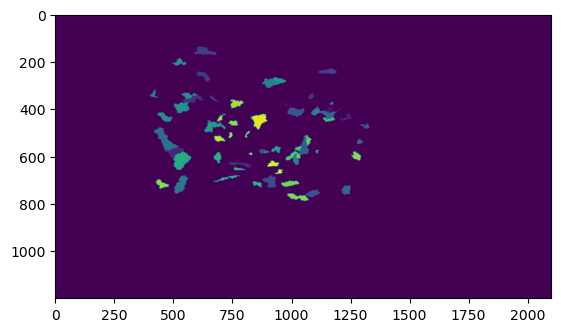

In [21]:
import matplotlib.pyplot as plt
plt.imshow(zones)

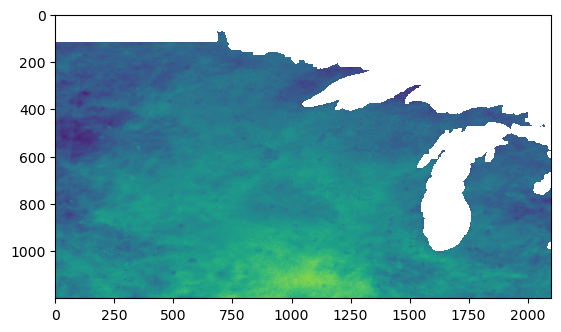

In [23]:
plt.imshow(seasonal_da[2,:,:].to_numpy())